In [36]:
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

# Data Generation

In [65]:
#this data is garbage but making just to have something to test the whole process with
n_rows = 5
n_features = 3
# feature data just normally distributed
features = np.random.normal(size=(n_rows, n_features))
# say that each feature predicts a single stock according to linear relationship with small error term
slopes = np.random.uniform(size = n_features)
errs = np.random.normal(scale=0.01, size = (n_rows, n_features))
true_ys = np.multiply(features, slopes) + errs


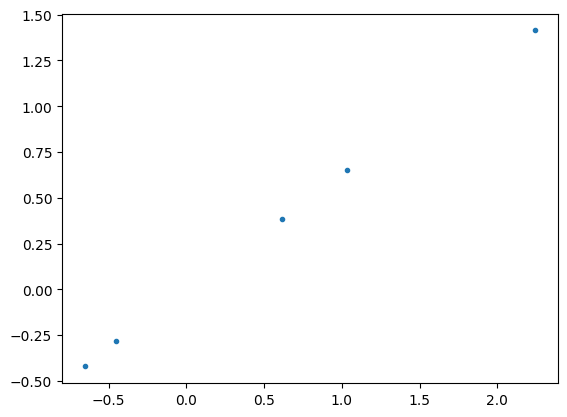

In [66]:
plt.plot(features[:,0], true_ys[:,0], '.')


# Generating Models to Ensemble

In [67]:
# first model predicts label mean everywhere

def h1(xs):
    # calculate label mean and duplicate it for each of xs
    return np.tile(np.average(ys, axis=0), (len(xs),1))
    

# second model predicts correct linear relationship for first stock and 0 everywhere else
def h2(xs):
    # build prediction 
    preds = np.zeros((len(xs), n_features))
    preds[:,0] = true_ys[:,0]
    return preds



Generating Conditioning Events for first debiasing method